# Prep

In [1]:
%%capture
# %pip install alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats
# %pip install talib-binary
# %pip install ta-lib

In [3]:
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
mpl.rcParams['figure.dpi'] = 250

from functools import lru_cache

API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')


@lru_cache()
def get_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")
  alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)
  data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol, tz=pytz.timezone('US/Eastern'))
  return data

In [4]:
import logging
from typing import Iterable, Optional
import json
import datetime


class DateTimeEncoder(json.JSONEncoder):
    # Override the default method
    def default(self, obj):
        if isinstance(obj, (datetime.date, datetime.datetime)):
            return obj.isoformat()


def append_jsonl(path: Optional[str], lines: Iterable[dict]):
    if not lines:
        logging.warning(f"no lines to write to csv {path}")

    f = open(path, "a") if path else None

    for line in lines:
        print(json.dumps(line, sort_keys=True, cls=DateTimeEncoder), file=f)

    if f:
        f.close()


# Strat

In [5]:
import datetime

FOR_ENTRY_AND_EXIT = "FOR_ENTRY_AND_EXIT"
FOR_ENTRY = "FOR_ENTRY"
NO = "NO"

class MyStrategy(bt.Strategy):
    params = dict(
        use_cci = FOR_ENTRY,
        cci_period = 20,
        cci_factor = 0.015,  # default, unconfirmed
        cci_upper = 100,
        cci_lower = -100,

        use_macd = FOR_ENTRY_AND_EXIT,
        macd_settings = (5, 21, 5),

        use_emacross = FOR_ENTRY,
        emas = (9, 20, 50),
        emas_cross_criteria_any_instead_of_all = True,
        emas_any_on_cross_instead_of_while_rightly_ordered = False,

        use_psar = FOR_ENTRY,
        psar_af = 0.018,
        psar_afmax = 0.2,
        psar_period = 2,

        use_psar_lookback = FOR_ENTRY,
        psar_lookback_period = 3,

        use_mfi = NO,
        mfi_upper = 80,
        mfi_lower = 20,

        # Must be strong
        # TODO: try shorter periods
        use_adx = FOR_ENTRY,
        adx_period = 14,
        adx_min_strength = 20,

        # Must be getting stronger
        use_adx_slope = FOR_ENTRY,
        adx_slope_smoothing_period = 5,

        start_of_morning = datetime.time(9, 32),
        end_of_morning = datetime.time(11, 30),
        start_of_afternoon = datetime.time(14, 30),
        end_of_day = datetime.time(15, 58),  # issues order 1m after
    )

    def add_signal(self, should_use: bool, long_signal, short_signal):
      if should_use not in (FOR_ENTRY, FOR_ENTRY_AND_EXIT):
        return
      
      if should_use == FOR_ENTRY:
        self.buy_long_signals.append(long_signal)
        self.buy_short_signals.append(short_signal)
      elif should_use == FOR_ENTRY_AND_EXIT:
        self.stay_long_signals.append(long_signal)
        self.stay_short_signals.append(short_signal)

    def __init__(self):
        self.stay_long_signals = []
        self.buy_long_signals = []

        self.stay_short_signals = []
        self.buy_short_signals = []

        if self.p.use_psar != NO:
          self.psar = bt.ind.PSAR(period=self.p.psar_period, af=self.p.psar_af, afmax=self.p.psar_afmax)
          self.add_signal(self.p.use_psar, self.psar.psar < self.data.close, self.psar.psar > self.data.close)
        
          if self.p.use_psar_lookback != NO:
            # PSAR signal should have been facing the other way 3m ago
            long_signal = self.psar.psar(-self.p.psar_lookback_period) > self.data.close(-self.p.psar_lookback_period)
            short_signal = self.psar.psar(-self.p.psar_lookback_period) < self.data.close(-self.p.psar_lookback_period)
            self.add_signal(self.p.use_psar_lookback, long_signal, short_signal)
        
        if self.p.use_adx != NO:
          self.adx = bt.ind.ADX(period=self.p.adx_period)
          self.add_signal(self.p.use_adx, self.adx > self.p.adx_min_strength, self.adx > self.p.adx_min_strength)
        
          if self.p.use_adx_slope != NO:
            self.add_signal(self.p.use_psar_lookback, self.adx.adx(0) - self.adx.adx(-1) > 0, self.adx.adx(0) - self.adx.adx(-1) > 0)
        
        
        if self.p.use_emacross != NO:
          ema_signals = []
          for ema_period in self.p.emas:
            signal = bt.ind.EMA(period=ema_period)
            setattr(self, f'ema_{ema_period}', signal)
            ema_signals.append(signal)

          if self.p.emas_cross_criteria_any_instead_of_all:
            long_signal = bt.Max(0, 1) > 1 # False
            short_signal = bt.Max(0, 1) > 1 # False
            for i in range(len(ema_signals) - 1):
              fast, slow = ema_signals[i], ema_signals[i + 1]

              if self.p.emas_any_on_cross_instead_of_while_rightly_ordered:
                # Whenever something crosses the right way
                long_signal = bt.Or(long_signal, bt.ind.CrossUp(fast, slow))
                short_signal = bt.Or(short_signal, bt.ind.CrossDown(fast, slow))
              else:
                # ANY must be in correct order
                long_signal = bt.Or(long_signal, fast > slow)
                short_signal = bt.Or(short_signal, fast < slow)

              
          else:
            # ALL must be in correct order
            long_signal = bt.Max(0, 1) > 0 # True
            short_signal = bt.Max(0, 1) > 0 # True
            for i in range(len(ema_signals) - 1):
              fast, slow = ema_signals[i], ema_signals[i + 1]
              # fastest > fast > ... > slow > slowest
              long_signal = bt.And(long_signal, fast > slow)
              # fastest < fast < ... < slow < slowest
              short_signal = bt.And(short_signal, fast < slow)
          
          self.add_signal(self.p.use_emacross, long_signal, short_signal)
        
        if self.p.use_macd in (FOR_ENTRY, FOR_ENTRY_AND_EXIT):
          period_me1, period_me2, period_signal = self.p.macd_settings
          self.macd = bt.ind.MACD(period_me1=period_me1, period_me2=period_me2, period_signal=period_signal)
          self.add_signal(self.p.use_macd, self.macd.macd > self.macd.signal, self.macd.macd < self.macd.signal)
        
        if self.p.use_cci in (FOR_ENTRY, FOR_ENTRY_AND_EXIT):
          self.cci = bt.ind.CCI(period=self.p.cci_period, factor=self.p.cci_factor, upperband=self.p.cci_upper, lowerband=self.p.cci_lower)
          self.add_signal(self.p.use_cci, self.cci.cci > self.p.cci_upper, self.cci.cci < self.p.cci_lower)
        
        if self.p.use_mfi in (FOR_ENTRY, FOR_ENTRY_AND_EXIT):
          self.mfi = bt.talib.MFI(self.data.high, self.data.low, self.data.close, self.data.volume)
          self.add_signal(self.p.use_mfi, self.mfi > self.p.mfi_upper, self.mfi < self.p.mfi_lower)

        self.stay_long = bt.And(*self.stay_long_signals, bt.Max(0, 1) > 0)
        self.buy_long = bt.And(self.stay_long, *self.buy_long_signals)
        
        self.stay_short = bt.And(*self.stay_short_signals, bt.Max(0, 1) > 0)
        self.buy_short = bt.And(self.stay_short, *self.buy_short_signals)


    def next(self):
      now = self.data.datetime.time()

      if not (now >= self.p.start_of_morning and now <= self.p.end_of_morning) and not (now >= self.p.start_of_afternoon and now < self.p.end_of_day):
        order = self.order_target_size(target=0)
        # if order:
          # print(f"exiting becaouse of timebox, {now}")
        return

      if self.position:
        if self.position.size > 0 and not self.stay_long:
          self.order_target_size(target=0)
        elif self.position.size < 0 and not self.stay_short:
          self.order_target_size(target=0)
      else:
        if self.buy_long:
          self.order_target_size(target=1)
        elif self.buy_short:
          self.order_target_size(target=-1)
        else:
          self.order_target_size(target=0)


# Results

In [6]:
def run_backtest(strategy, symbol: str, start: str, end: str, params, timeframe=TimeFrame.Minute, cash=10000):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
  cerebro.adddata(get_data(symbol, timeframe, start, end))
 
  results = cerebro.run()

  cerebro.plot(iplot=False)

  strat = results[0]
  return strat

strategy = run_backtest(MyStrategy, "AAPL", "2022-01-01", "2022-05-01",
  # {'use_cci': 'FOR_ENTRY', 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': -1000, 'cci_lower': 1000, 'use_macd': 'FOR_ENTRY_AND_EXIT', 'macd_settings': (5, 21, 5), 'use_emacross': 'FOR_ENTRY', 'emas': (9, 20, 50), 'emas_cross_criteria_any_instead_of_all': True, 'emas_any_on_cross_instead_of_while_rightly_ordered': False, 'use_psar': 'FOR_ENTRY', 'psar_af': 0.018, 'psar_afmax': 0.2, 'psar_period': 2, 'use_mfi': 'FOR_ENTRY', 'mfi_upper': 0, 'mfi_lower': 100, 'start_of_morning': datetime.time(9, 32), 'end_of_morning': datetime.time(11, 30), 'start_of_afternoon': datetime.time(14, 30), 'end_of_day': datetime.time(15, 58)}
  {
      'use_cci': 'FOR_ENTRY',
      'cci_period': 20,
      'cci_factor': 0.015,
      'cci_upper': -1000,
      'cci_lower': -100,
      'use_macd': 'FOR_ENTRY',
      'macd_settings': (5, 21, 5),
      'use_emacross': 'FOR_ENTRY',
      'emas': (9, 20, 50),
      'emas_cross_criteria_any_instead_of_all': True,
      'emas_any_on_cross_instead_of_while_rightly_ordered': False,
      'use_psar': 'FOR_ENTRY',
      'psar_af': 0.018,
      'psar_afmax': 0.2,
      'psar_period': 2,
      'use_psar_lookback': 'FOR_ENTRY',
      'psar_lookback_period': 3,
      'use_mfi': 'FOR_ENTRY',
      'mfi_upper': 0,
      'mfi_lower': 100,
      'use_adx': 'FOR_ENTRY',
      'adx_period': 14,
      'adx_min_strength': 20,
      'use_adx_slope': 'NO',
      'adx_slope_smoothing_period': 5,
      'start_of_morning': datetime.time(9, 32),
      'end_of_morning': datetime.time(11, 30),
      'start_of_afternoon': datetime.time(14, 30),
      'end_of_day': datetime.time(15, 58)
  }
  , cash=200, timeframe=TimeFrame(1, TimeFrameUnit.Minute)
)

{'use_cci': 'FOR_ENTRY', 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': -1000, 'cci_lower': -100, 'use_macd': 'FOR_ENTRY', 'macd_settings': (5, 21, 5), 'use_emacross': 'FOR_ENTRY', 'emas': (9, 20, 50), 'emas_cross_criteria_any_instead_of_all': True, 'emas_any_on_cross_instead_of_while_rightly_ordered': False, 'use_psar': 'FOR_ENTRY', 'psar_af': 0.018, 'psar_afmax': 0.2, 'psar_period': 2, 'use_psar_lookback': 'FOR_ENTRY', 'psar_lookback_period': 3, 'use_mfi': 'FOR_ENTRY', 'mfi_upper': 0, 'mfi_lower': 100, 'use_adx': 'FOR_ENTRY', 'adx_period': 14, 'adx_min_strength': 20, 'use_adx_slope': 'NO', 'adx_slope_smoothing_period': 5, 'start_of_morning': datetime.time(9, 32), 'end_of_morning': datetime.time(11, 30), 'start_of_afternoon': datetime.time(14, 30), 'end_of_day': datetime.time(15, 58)}
Drawdown: 6.1%
Average : 132 trades @ 0.23
Winners : 56.8% @ 1.19
Losers  : 43.2% @ -1.02



                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2022-04-29
Risk-Free Rate      0.0%
Time in Market      98.0%

Cumulative Return   15.29%
CAGR﹪              56.47%

Sharpe              3.05
Sortino             5.16
Sortino/√2          3.65
Omega               1.66

Max Drawdown        -5.37%
Longest DD Days     27

Gain/Pain Ratio     0.66
Gain/Pain (1M)      4.26

Payoff Ratio        1.05
Profit Factor       1.66
Common Sense Ratio  2.06
CPC Index           1.07
Tail Ratio          1.24
Outlier Win Ratio   3.54
Outlier Loss Ratio  2.55

MTD                 3.92%
3M                  11.54%
6M                  15.29%
YTD                 15.29%
1Y                  15.29%
3Y (ann.)           56.47%
5Y (ann.)           56.47%
10Y (ann.)          56.47%
All-time (ann.)     56.47%

Avg. Drawdown       -1.84%
Avg. Drawdown Days  10
Recovery Factor     2.85
Ulcer Index         0.02
Serenity Index      2.42


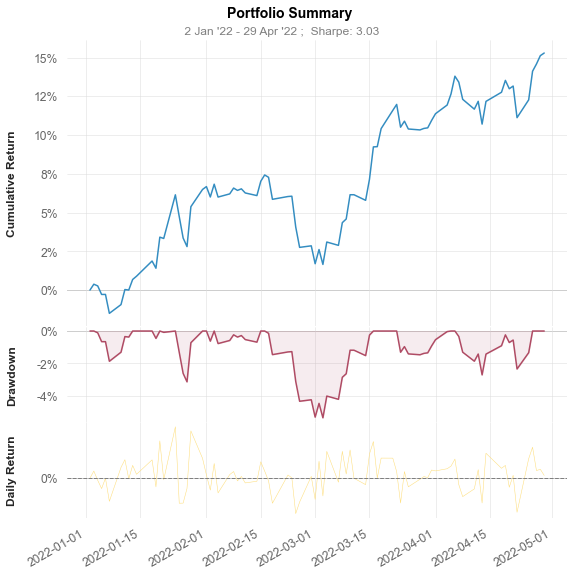

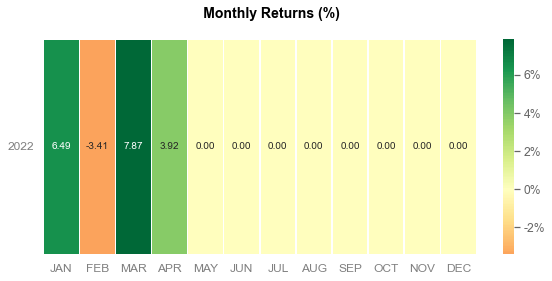

In [7]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
print(strategy.p.__dict__)
# print(f"ROI     : {annual_returns[2021]:.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")
print()

import quantstats

portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()

returns.index = returns.index.tz_convert(None)

# pretend we using options
returns = returns * 1
quantstats.reports.basic(returns)

In [8]:
import os

output_path = "/tmp/trades.jsonl"
try:
  os.remove(output_path)
except:
  pass

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

position = 0
orders = []
for record in transactions.to_dict('records'):
  position += record['amount']
  orders.append(record)
  if position == 0:
    entry, exitry = orders

    quantity = entry['amount']
    entry_price = entry['price']
    exit_price = exitry['price']

    append_jsonl(output_path, [{
        "symbol": "AAPL",
        "opened_at": entry['time'].to_pydatetime(),
        "closed_at": exitry['time'].to_pydatetime(),
        "quantity": quantity,

        "bought_cost": quantity*entry_price,
        "sold_cost": quantity*exit_price,

        "bought_price": entry_price,
        "sold_price": exit_price,
        "price_difference": exit_price - entry_price,

        "profit_loss": (quantity*exit_price - quantity*entry_price),
        "roi": (quantity*exit_price - quantity*entry_price) / (quantity*entry_price),
        "is_win": quantity*exit_price > quantity*entry_price,
    }])
    orders = []

In [ ]:
try:
    from google.colab import files
    files.download(output_path)
except:
    pass

# Optimize

In [11]:
def backtest_optimize_parameters(symbol: str, start: str, end: str, params, timeframe=TimeFrame.Minute, cash=10000):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.optstrategy(MyStrategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.adddata(get_data(symbol, timeframe, start, end))
 
  runs = cerebro.run()
  for results in runs:
    strategy = results[0]
    yield strategy

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [13]:
gridsearch = dict(
    use_cci = [FOR_ENTRY], # NO = both upper and lower ignore
    cci_period = [20],
    cci_factor = [0.015],
    cci_upper = [-1000],
    cci_lower = [-100],

    use_macd = [NO],
    macd_settings = [
      (5, 21, 5),
    ],

    use_emacross = [FOR_ENTRY],
    emas = [
      (9, 20, 50),
    ],
    # emas_cross_criteria_any_instead_of_all = [True, False],
    # emas_any_on_cross_instead_of_while_rightly_ordered = [True, False],
    emas_cross_criteria_any_instead_of_all = [True],
    emas_any_on_cross_instead_of_while_rightly_ordered = [False],

    use_psar = [FOR_ENTRY],
    psar_af = [0.018],
    psar_afmax = [0.2],
    psar_period = [2],

    use_psar_lookback = [FOR_ENTRY],
    psar_lookback_period = [3],

    # use_mfi = [FOR_ENTRY, FOR_ENTRY_AND_EXIT], # NO = both upper and lower ignore
    use_mfi = [NO], # NO = both upper and lower ignore
    mfi_upper = [80], # 0=ignore
    mfi_lower = [20], # 100=ignore

    # Must be strong
    # TODO: try shorter periods
    use_adx = [FOR_ENTRY],
    adx_period = [14],
    adx_min_strength = [20],

    # Must be getting stronger
    # TODO: FOR_ENTRY_AND_EXIT
    use_adx_slope = [NO],
    adx_slope_smoothing_period = [5],

    start_of_morning =   [datetime.time( 9, 32)],
    end_of_morning =     [datetime.time(11, 30)],
    start_of_afternoon = [datetime.time(14, 30)],
    end_of_day =         [datetime.time(15, 58)],  # issues order 1m after
)

from datetime import timedelta

time_per = timedelta(seconds=13)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(200)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
cerebro.adddata(get_data("AAPL", TimeFrame(1, TimeFrameUnit.Minute), "2022-01-01", "2022-05-01"))

runs = cerebro.run()
backtest_results = [results[0] for results in runs]



end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

for strategy in list(sorted(backtest_results, key=get_roi, reverse=True))[:10]:
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  if analysis["total"]["total"] == 0:
    continue
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  print(strategy.p.__dict__)
  print(f"ROI     : {get_roi(strategy):.1%}")
  print(f"Drawdown: {get_max_drawdown(strategy):.1%}")
  print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
  print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
  print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")
  print()

Estimated time (@ 0:00:13, 1): 0:00:13
(ending at 2022-05-09 12:13:45.275616)
Done. Took 0:00:19.542166
time per: 0:00:19.542166
{'use_cci': 'FOR_ENTRY', 'cci_period': 20, 'cci_factor': 0.015, 'cci_upper': -1000, 'cci_lower': -100, 'use_macd': 'NO', 'macd_settings': (5, 21, 5), 'use_emacross': 'FOR_ENTRY', 'emas': (9, 20, 50), 'emas_cross_criteria_any_instead_of_all': True, 'emas_any_on_cross_instead_of_while_rightly_ordered': False, 'use_psar': 'FOR_ENTRY', 'psar_af': 0.018, 'psar_afmax': 0.2, 'psar_period': 2, 'use_psar_lookback': 'FOR_ENTRY', 'psar_lookback_period': 3, 'use_mfi': 'NO', 'mfi_upper': 80, 'mfi_lower': 20, 'use_adx': 'FOR_ENTRY', 'adx_period': 14, 'adx_min_strength': 20, 'use_adx_slope': 'NO', 'adx_slope_smoothing_period': 5, 'start_of_morning': datetime.time(9, 32), 'end_of_morning': datetime.time(11, 30), 'start_of_afternoon': datetime.time(14, 30), 'end_of_day': datetime.time(15, 58)}
ROI     : 16.4%
Drawdown: 4.0%
Average : 135 trades @ 0.24
Winners : 57.0% @ 1.22
L